In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from yellowbrick.regressor import PredictionError
import smogn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor, BaggingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

# 3. Modeling

Import processed_data after the EDA process.

In [4]:
df = pd.read_csv("processed_data.csv",sep=",",index_col=0)

Verify the dataframe. We have 15 numerical features  ready to be used for model training.

In [6]:
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,publisher_average_rating,author_average_rating,number_occurrence,author_average_page,author_book_count,language_average_rating,publication_year,rate_occurrence,review_weight,rating_weight_,rate_per_pages
0,4.57,652,2095690,27591,4.06,4.55,2,902.00,6,3.93,2006.00,9.14,126090.87,9577303.30,2979.64
1,4.49,870,2153167,29221,4.06,4.55,1,902.00,6,3.93,2004.00,4.49,131202.29,9667719.83,3906.30
2,4.42,352,6333,244,3.98,4.51,2,728.55,11,3.93,2003.00,8.84,1078.48,27991.86,1555.84
3,4.56,435,2339585,36325,4.06,4.55,2,902.00,6,3.93,2004.00,9.12,165642.00,10668507.60,1983.60
4,4.78,2690,41428,164,3.98,4.55,1,902.00,6,3.93,2004.00,4.78,783.92,198025.84,12858.20


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11127 entries, 0 to 11126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_rating            11127 non-null  float64
 1   num_pages                 11127 non-null  int64  
 2   ratings_count             11127 non-null  int64  
 3   text_reviews_count        11127 non-null  int64  
 4   publisher_average_rating  11127 non-null  float64
 5   author_average_rating     11127 non-null  float64
 6   number_occurrence         11127 non-null  int64  
 7   author_average_page       11127 non-null  float64
 8   author_book_count         11127 non-null  int64  
 9   language_average_rating   11127 non-null  float64
 10  publication_year          11127 non-null  float64
 11  rate_occurrence           11127 non-null  float64
 12  review_weight             11127 non-null  float64
 13  rating_weight_            11127 non-null  float64
 14  rate_per_pa

We will explore the relationships between variables

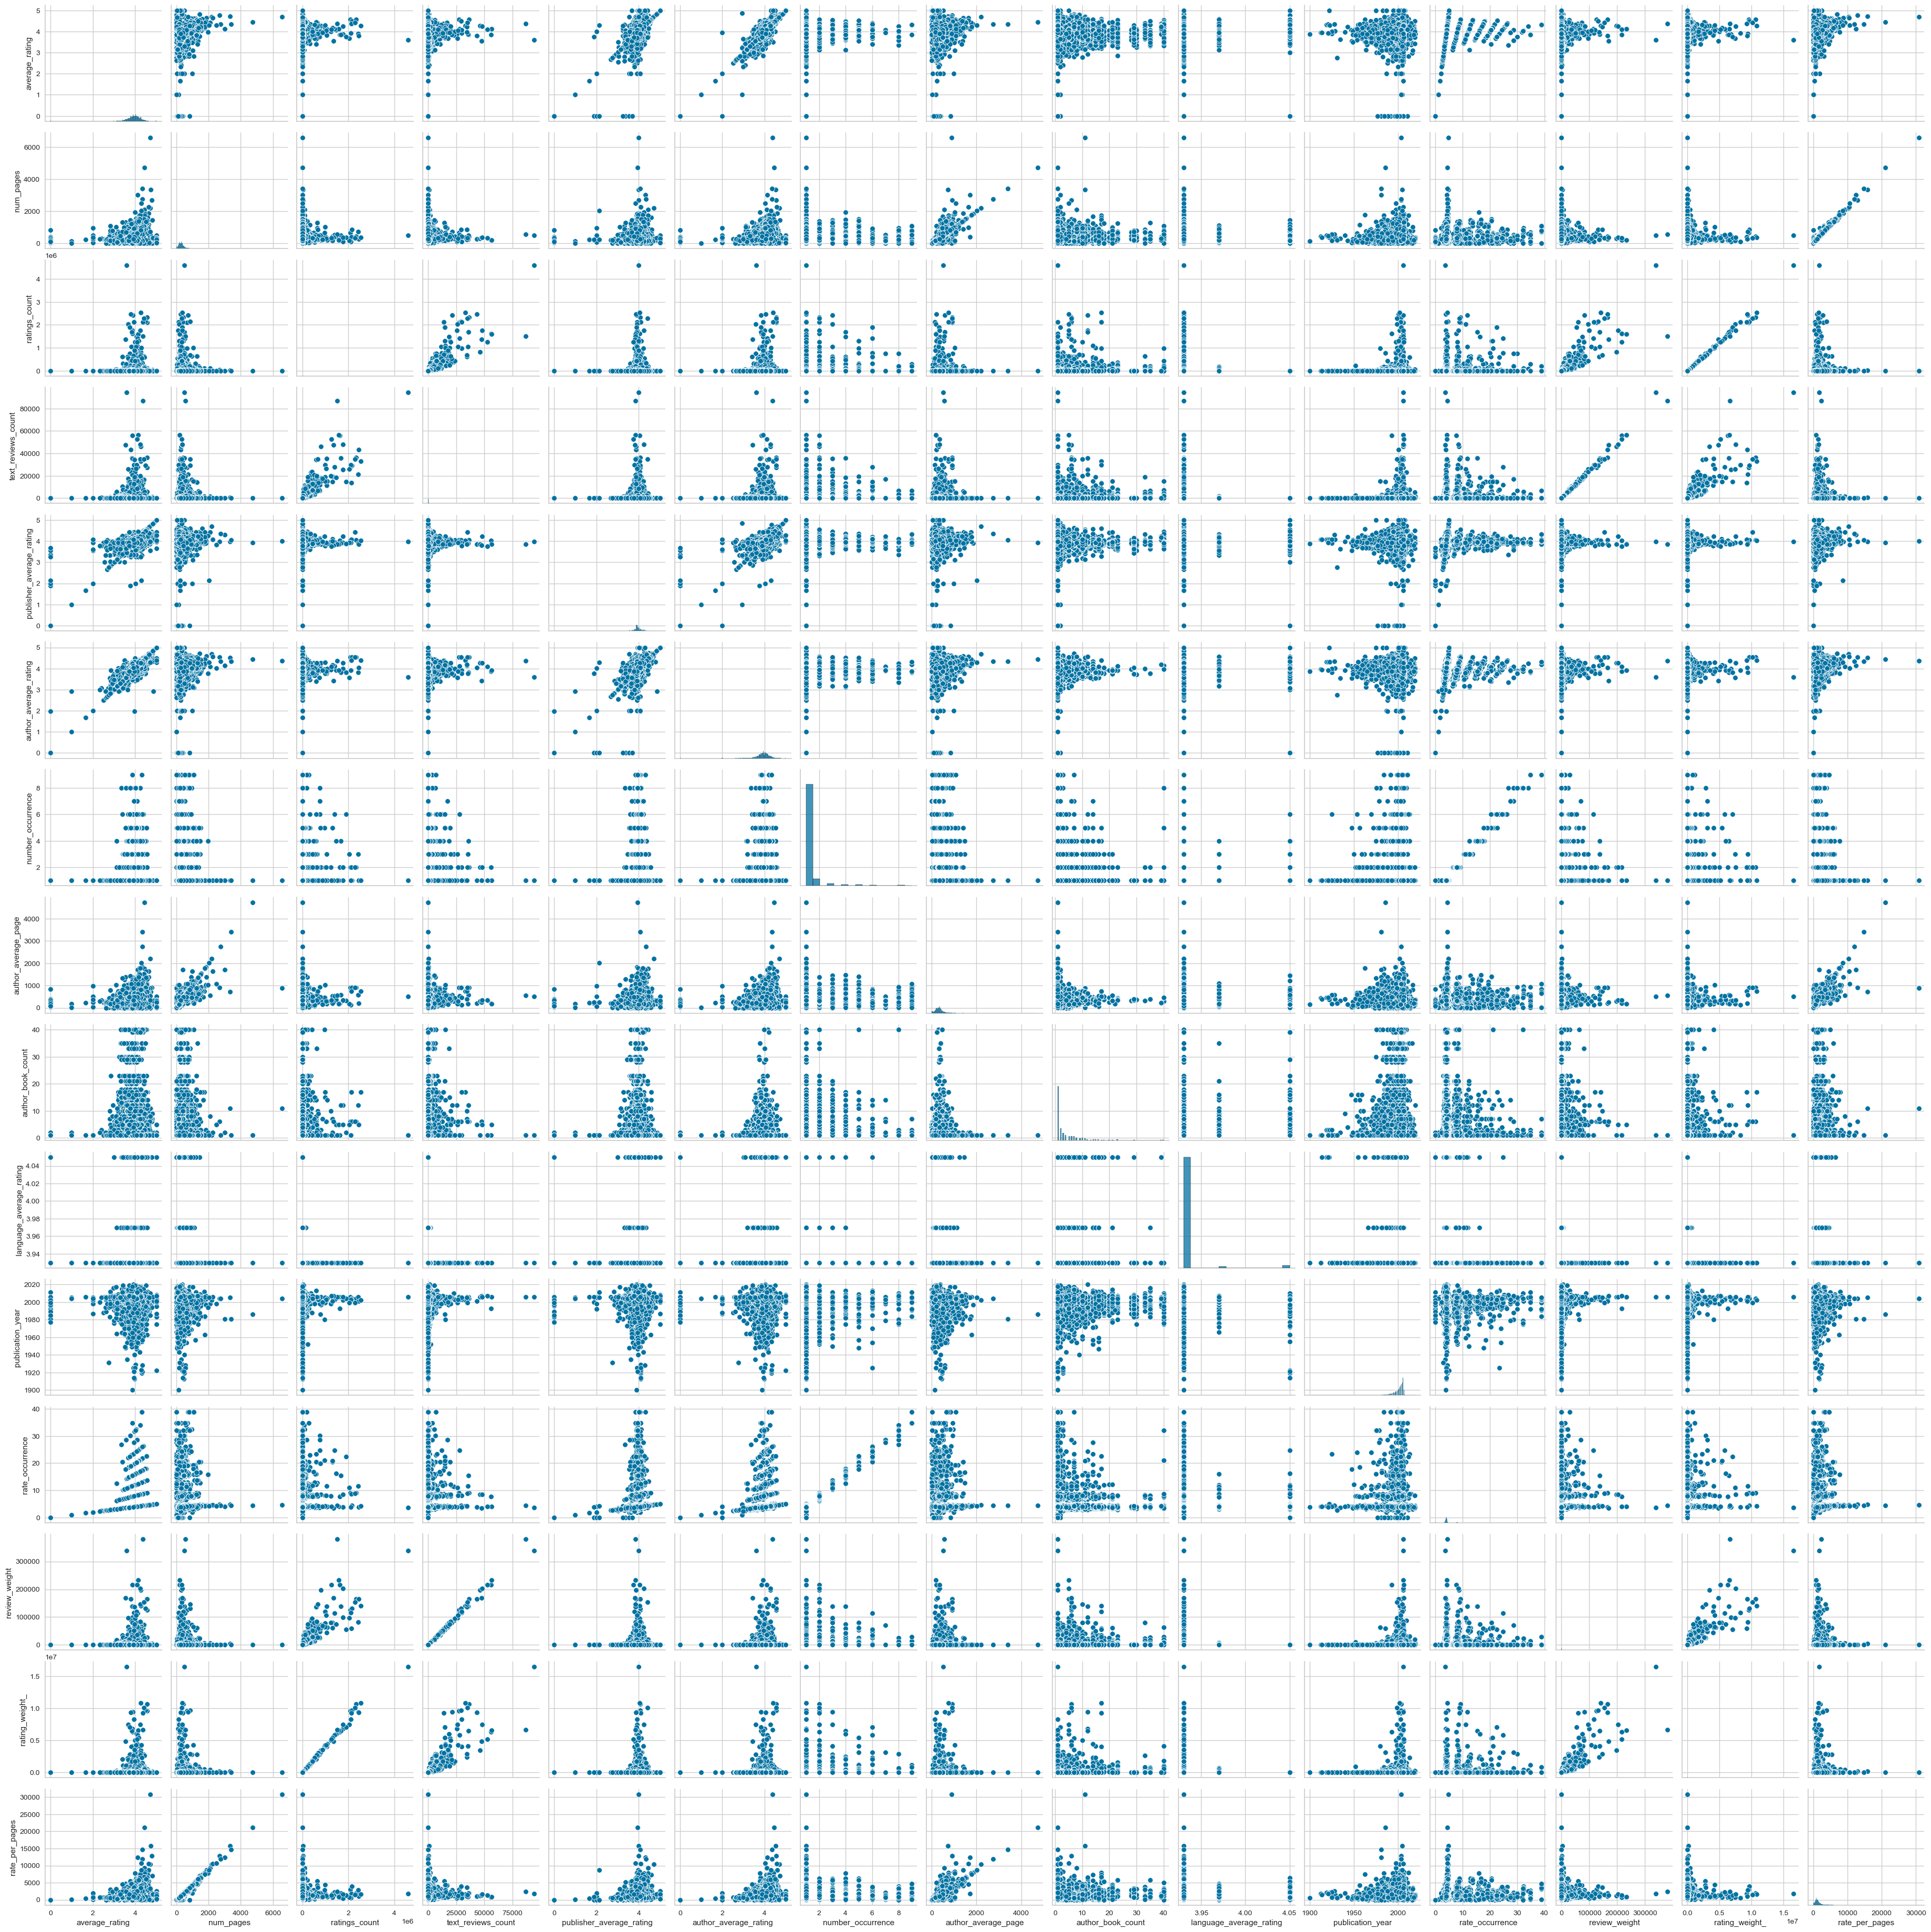

In [9]:
sns.pairplot(df)
plt.show()

As well as checking the correlations of the variables.

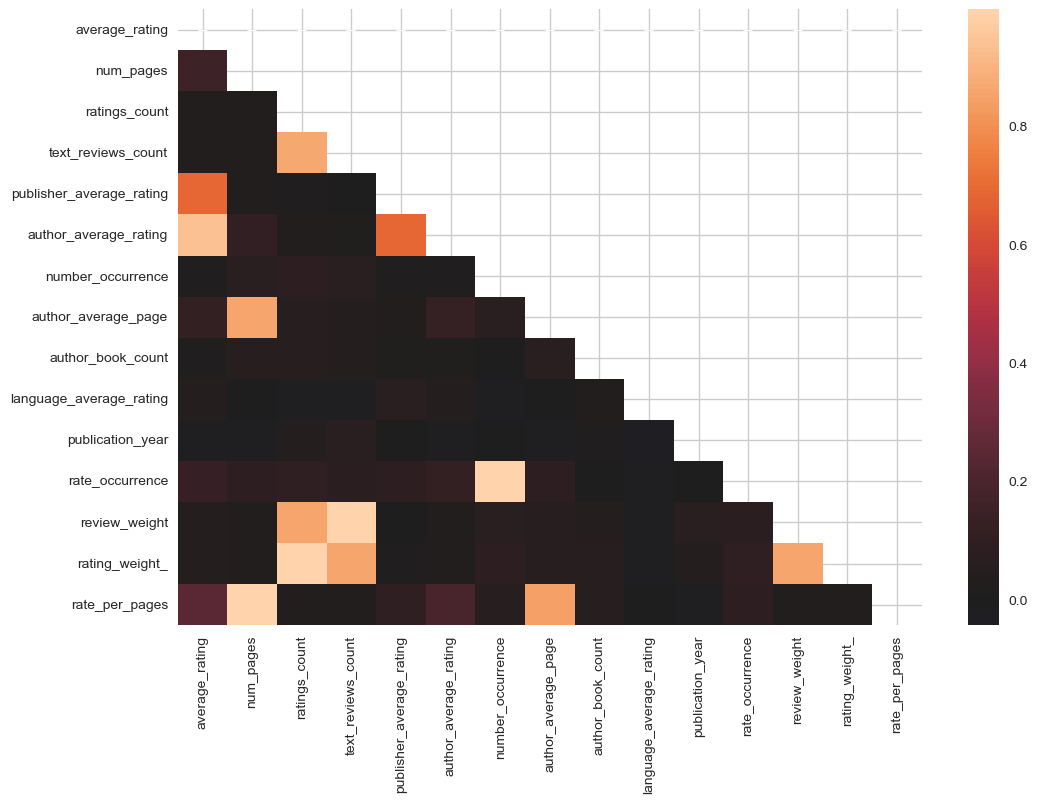

In [11]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 8)) 

sns.heatmap(corr, mask=mask, annot=True, center=0)

plt.show()

Separate features and target.

In [13]:
X = df.drop(columns=['average_rating'])
y = df['average_rating']

In [14]:
X

,num_pages,ratings_count,text_reviews_count,publisher_average_rating,author_average_rating,number_occurrence,author_average_page,author_book_count,language_average_rating,publication_year,rate_occurrence,review_weight,rating_weight_,rate_per_pages
0,652,2095690,27591,4.06,4.55,2,902.00,6,3.93,2006.00,9.14,126090.87,9577303.30,2979.64
1,870,2153167,29221,4.06,4.55,1,902.00,6,3.93,2004.00,4.49,131202.29,9667719.83,3906.30
2,352,6333,244,3.98,4.51,2,728.55,11,3.93,2003.00,8.84,1078.48,27991.86,1555.84
3,435,2339585,36325,4.06,4.55,2,902.00,6,3.93,2004.00,9.12,165642.00,10668507.60,1983.60
4,2690,41428,164,3.98,4.55,1,902.00,6,3.93,2004.00,4.78,783.92,198025.84,12858.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,512,156,20,3.97,4.06,1,512.00,1,3.93,2004.00,4.06,81.20,633.36,2078.72
11123,635,783,56,3.92,3.87,1,491.00,5,3.93,1988.00,4.08,228.48,3194.64,2590.80
11124,415,820,95,3.92,3.87,1,491.00,5,3.93,1993.00,3.96,376.20,3247.20,1643.40
11125,434,769,139,3.77,3.87,1,491.00,5,3.93,2007.00,3.72,517.08,2860.68,1614.48


In [15]:
y

0       4.57
1       4.49
2       4.42
3       4.56
4       4.78
        ... 
11122   4.06
11123   4.08
11124   3.96
11125   3.72
11126   3.91
Name: average_rating, Length: 11127, dtype: float64

Split the data into training and testing sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verify the dimensions.

In [19]:
X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim

(2, 2, 1, 1)

Check the number of rows and columns.

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8901, 14), (2226, 14), (8901,), (2226,))

We use LazyRegressor model to compare the performance of various regression models.

In [23]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

 21%|█████████████████▊                                                                 | 9/42 [00:11<00:50,  1.52s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [01:14<00:25,  2.31s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:23<00:00,  1.99s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,1.00,1.00,0.02,7.74
BaggingRegressor,1.00,1.00,0.02,1.35
LGBMRegressor,1.00,1.00,0.02,0.24
XGBRegressor,0.99,0.99,0.03,0.12
DecisionTreeRegressor,0.99,0.99,0.03,0.19
HistGradientBoostingRegressor,0.99,0.99,0.03,1.75
GradientBoostingRegressor,0.99,0.99,0.03,5.33
MLPRegressor,0.97,0.97,0.06,2.80
ExtraTreesRegressor,0.96,0.97,0.06,5.96


We will evaluate the below 6 models.
- LinearRegression
- DecisionTreeRegressor
- LGBMRegressor
- BaggingRegressor
- XGBRegressor
- HistGradientBoostingRegressor

We use LinearRegression as a baseline model. The rest of the models were selected based on their competitive error scores and minimal time taken.

Train, evaluate, and visualize each model's prediction and feature importance.


Baseline LinearRegression
Mean Squared Error (MSE): 0.011724472095062454
Root Mean Squared Error (RMSE): 0.10827960147258787
Mean Absolute Error (MAE): 0.05773766463217546
R^2 Score: 0.9030696833289421


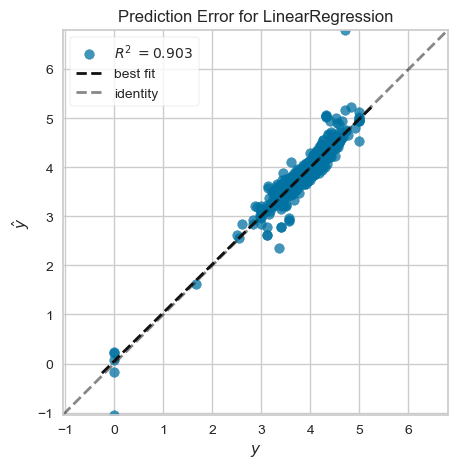

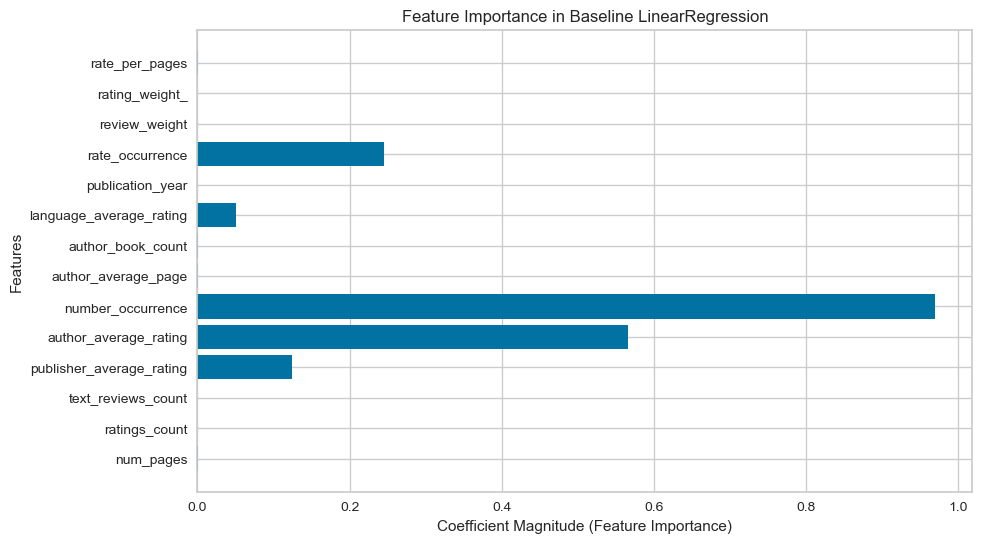


DecisionTreeRegressor
Mean Squared Error (MSE): 0.0009543575920934417
Root Mean Squared Error (RMSE): 0.030892678616355716
Mean Absolute Error (MAE): 0.004654088050316047
R^2 Score: 0.9921099915741193


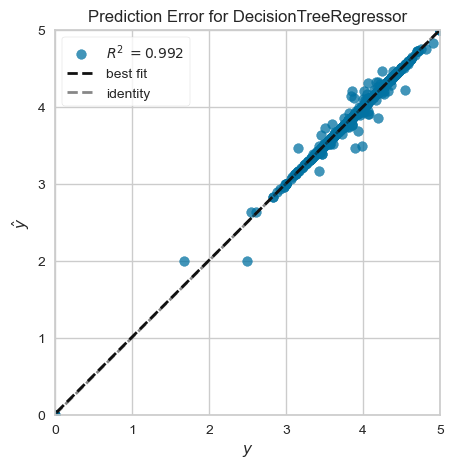

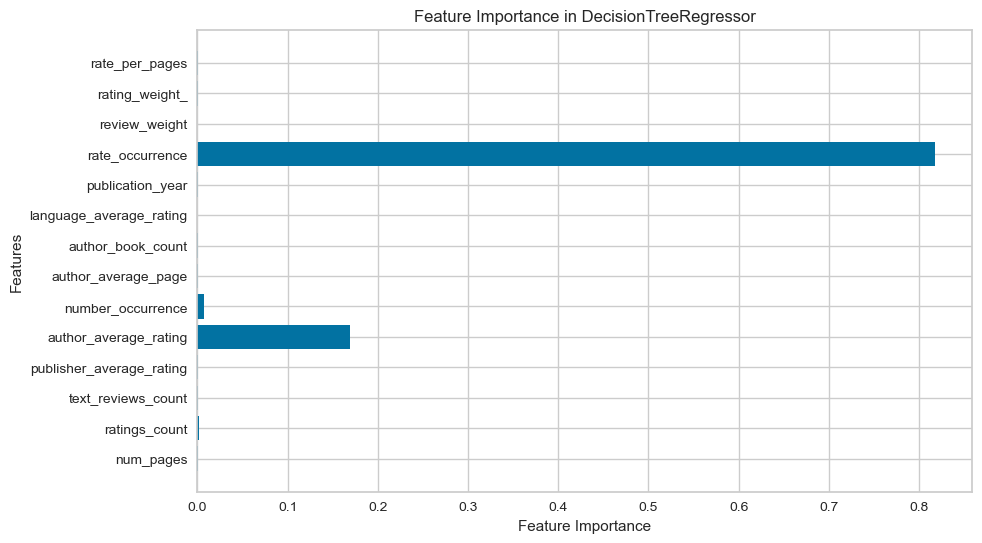


LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881
Mean Squared Error (MSE): 0.0006725079981571614
Root Mean Squared Error (RMSE): 0.025932759169767523
Mean Absolute Error (MAE): 0.007096115278040443
R^2 Score: 0.9944401408697416


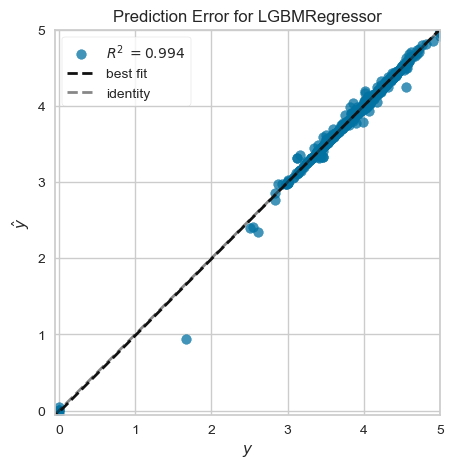

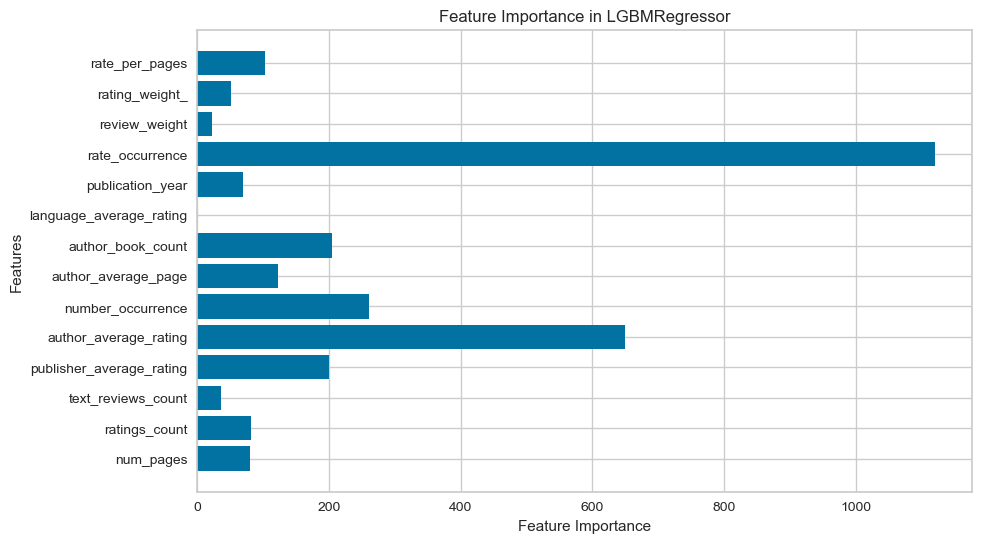


BaggingRegressor
Mean Squared Error (MSE): 0.00044357053009883246
Root Mean Squared Error (RMSE): 0.021061114170404956
Mean Absolute Error (MAE): 0.004571428571429278
R^2 Score: 0.9963328470911252


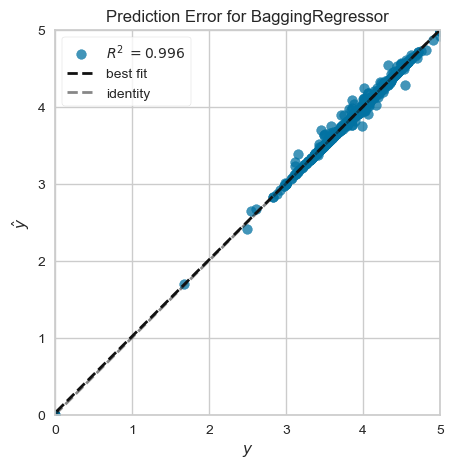

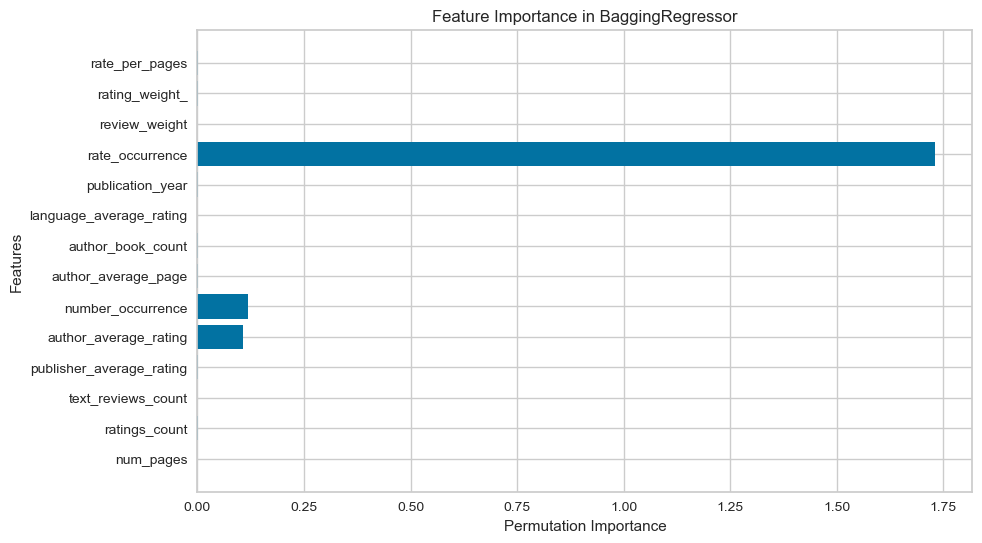


XGBRegressor
Mean Squared Error (MSE): 0.0007309968289581342
Root Mean Squared Error (RMSE): 0.027036953026517877
Mean Absolute Error (MAE): 0.007839586774283903
R^2 Score: 0.9939565932229656


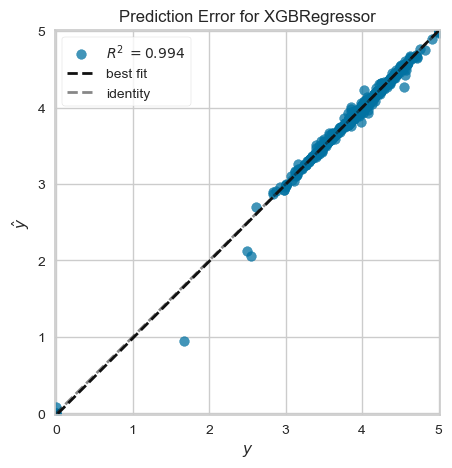

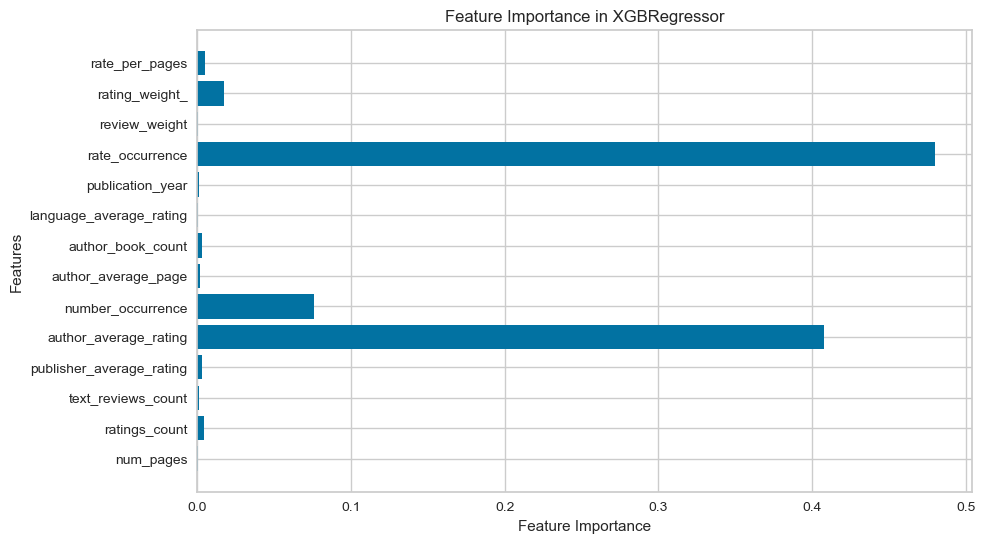


HistGradientBoostingRegressor
Mean Squared Error (MSE): 0.0010755467453936822
Root Mean Squared Error (RMSE): 0.03279552935071612
Mean Absolute Error (MAE): 0.008481010407253338
R^2 Score: 0.9911080784038507


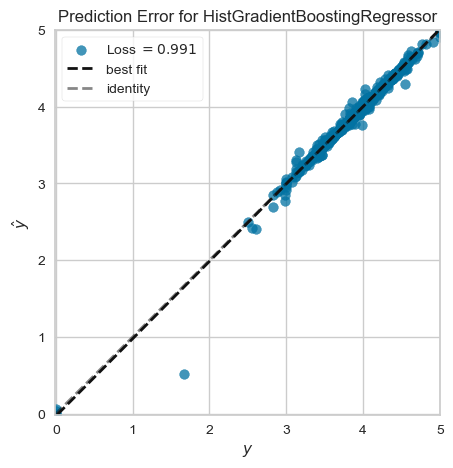

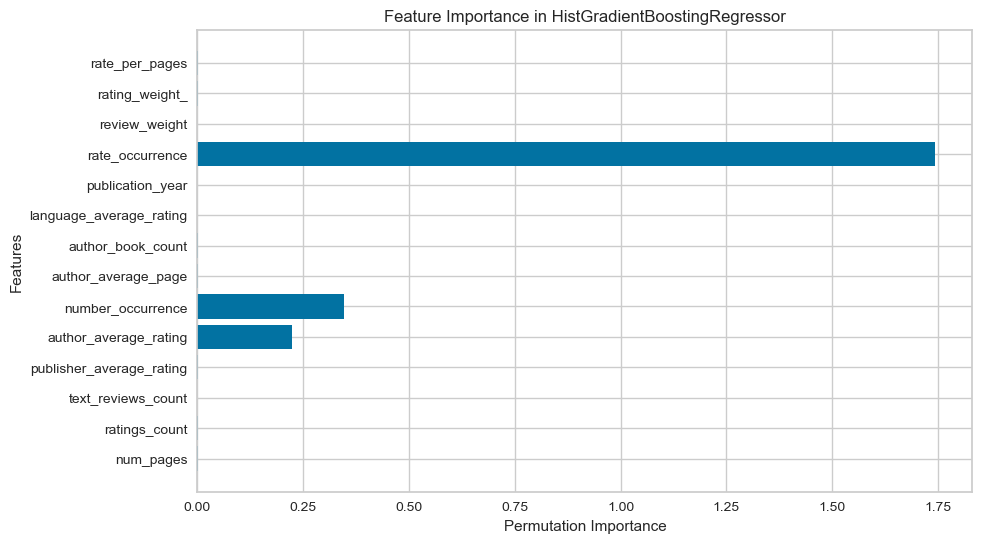

In [26]:
# Initialize the models
models = {
    'Baseline LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'BaggingRegressor': BaggingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor()
}

for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    
    # Visualize prediction error
    fig = plt.figure(figsize=(5, 5))
    viz = PredictionError(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    
    # Plot feature importance if available or calculate it
    plt.figure(figsize=(10, 6))
    
    if hasattr(model, 'feature_importances_'):
        # Models with feature_importances_ attribute
        feature_importances = model.feature_importances_
        plt.barh(X_train.columns, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {name}')
    
    elif hasattr(model, 'coef_'):
        # Linear models with coefficients
        feature_importances = np.abs(model.coef_)
        plt.barh(X_train.columns, feature_importances)
        plt.xlabel('Coefficient Magnitude (Feature Importance)')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {name}')
    
    else:
        # For models without built-in importance (use permutation importance)
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importances = result.importances_mean
        plt.barh(X_train.columns, feature_importances)
        plt.xlabel('Permutation Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {name}')
    
    plt.show()


Feature importance using HistGradientBoostingRegressor

In [28]:
# Calculate feature importance as percentages
feature_importance = 100.0 * (feature_importances / feature_importances.sum())

# Create a DataFrame to show the features and their corresponding importance percentages
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance (%)': feature_importance
})

# Sort by importance (highest first)
feature_importance_df = feature_importance_df.sort_values(by='Importance (%)', ascending=False)

# Display the feature importance
print("Feature importance using", name)
print(feature_importance_df)

Feature importance using HistGradientBoostingRegressor
                     Feature  Importance (%)
10           rate_occurrence           75.15
5          number_occurrence           14.89
4      author_average_rating            9.65
13            rate_per_pages            0.07
12            rating_weight_            0.06
7          author_book_count            0.05
3   publisher_average_rating            0.05
6        author_average_page            0.05
1              ratings_count            0.02
0                  num_pages            0.01
2         text_reviews_count            0.00
9           publication_year            0.00
11             review_weight            0.00
8    language_average_rating            0.00


Compare each model's metrics to find the model with the best MSE score.

In [30]:
metrics = {}

# Baseline model (mean model)
dummy = LinearRegression()
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
metrics['Baseline Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_dummy_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_dummy_pred)),
    'MAE': mean_absolute_error(y_test, y_dummy_pred),
    'R-Squared': r2_score(y_test, y_dummy_pred)
}

# DecisionTreeRegressor
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)
y_dtr_pred = dtr_model.predict(X_test)
metrics['DecisionTree Regression'] = {
    'MSE': mean_squared_error(y_test, y_dtr_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_dtr_pred)),
    'MAE': mean_absolute_error(y_test, y_dtr_pred),
    'R-Squared': r2_score(y_test, y_dtr_pred)
}

# LGBMRegressor
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
y_lgbm_pred = lgbm_model.predict(X_test)
metrics['LGBM Regression'] = {
    'MSE': mean_squared_error(y_test, y_lgbm_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_lgbm_pred)),
    'MAE': mean_absolute_error(y_test, y_lgbm_pred),
    'R-Squared': r2_score(y_test, y_lgbm_pred)
}

# BaggingRegressor
bagging_model = BaggingRegressor(random_state=42)
bagging_model.fit(X_train, y_train)
y_bagging_pred = bagging_model.predict(X_test)
metrics['Bagging Regression'] = {
    'MSE': mean_squared_error(y_test, y_bagging_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_bagging_pred)),
    'MAE': mean_absolute_error(y_test, y_bagging_pred),
    'R-Squared': r2_score(y_test, y_bagging_pred)
}

# XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
metrics['XGB Regression'] = {
    'MSE': mean_squared_error(y_test, y_xgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_xgb_pred)),
    'MAE': mean_absolute_error(y_test, y_xgb_pred),
    'R-Squared': r2_score(y_test, y_xgb_pred)
}

# HistGradientBoostingRegressor
hgb_model = HistGradientBoostingRegressor()
hgb_model.fit(X_train, y_train)
y_hgb_pred = hgb_model.predict(X_test)
metrics['HistGradient Boosting Regression'] = {
    'MSE': mean_squared_error(y_test, y_hgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_hgb_pred)),
    'MAE': mean_absolute_error(y_test, y_hgb_pred),
    'R-Squared': r2_score(y_test, y_hgb_pred)
}

# Identify the best model based on MSE
best_model = min(metrics, key=lambda x: metrics[x]['MSE'])

print(f"\nBest Model based on MSE: {best_model}")

# Initialize best_predictions
best_predictions = None # Assign best_predictions based on the best_model
if best_model == 'Baseline Linear Regression':
    best_predictions = y_dummy_pred
elif best_model == 'DecisionTree Regression':
    best_predictions = y_dtr_pred
elif best_model == 'LGBM Regression':
    best_predictions = y_lgbm_pred
elif best_model == 'Bagging Regression':
    best_predictions = y_bagging_pred
elif best_model == 'XGB Regression':
    best_predictions = y_xgb_pred
elif best_model == 'HistGradient Boosting Regression':
    best_predictions = y_hgb_pred

# Calculate and print additional metrics for the best model
best_mse = mean_squared_error(y_test, best_predictions)
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)

print(f'\nMSE for {best_model}: {best_mse}')
print(f'RMSE for {best_model}: {best_rmse}')
print(f'Mean Absolute Error for {best_model}: {best_mae}')
print(f'R-squared for {best_model}: {best_r2}')



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881

Best Model based on MSE: Bagging Regression

MSE for Bagging Regression: 0.00044357053009883246
RMSE for Bagging Regression: 0.021061114170404956
Mean Absolute Error for Bagging Regression: 0.004571428571429278
R-squared for Bagging Regression: 0.9963328470911252


Compare the predicted data to the actual data.

In [32]:
comparison= pd.DataFrame({'Actual': y_test, 'Predicted': y_bagging_pred, 'Residual': y_test - y_bagging_pred})

In [33]:
comparison

,Actual,Predicted,Residual
8663,3.92,3.92,-0.00
483,3.97,3.97,-0.00
8403,4.09,4.09,-0.00
6382,4.02,4.02,0.00
1844,4.16,4.16,0.00
...,...,...,...
2344,3.83,3.83,0.00
4099,3.84,3.84,-0.00
5594,4.25,4.25,0.00
4605,4.45,4.45,-0.00


# 4. Fine Tuning

We fine tune the BaggingRegressor model by the below parameters.

In [36]:
model_tuning = BaggingRegressor(random_state=42, verbose=1, warm_start=True, n_estimators=20)
model_tuning.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


BaggingRegressor(n_estimators=20, random_state=42, verbose=1, warm_start=True)

We improved the accuracy score from 0.9963328470911252 ~ 99.63% to 99.67%

In [38]:
print(round(model_tuning.score(X_test, y_test),4)*100,"%")

99.67 %


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [39]:
y_tuning = model_tuning.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Regenerate the metrics after fine tuning.

In [41]:
print(f'\nMSE for BaggingRegressor: {mean_squared_error(y_test,y_tuning)}')
print(f'RMSE for BaggingRegressor: {np.sqrt(mean_squared_error(y_test,y_tuning))}')
print(f'Mean Absolute Error for BaggingRegressor: {mean_absolute_error(y_test,y_tuning)}')
print(f'R-squared for BaggingRegressor: {r2_score(y_test,y_tuning)}')


MSE for BaggingRegressor: 0.00040361287061994584
RMSE for BaggingRegressor: 0.02009011873085736
Mean Absolute Error for BaggingRegressor: 0.004288634321654111
R-squared for BaggingRegressor: 0.9966631910550428


Save the best model as a file.

In [43]:
!pip install joblib

In [44]:
from joblib import dump, load

In [45]:
dump(model_tuning,"best_model.pkl")

['best_model.pkl']

In [46]:
saved_model = load("best_model.pkl")
saved_model

BaggingRegressor(n_estimators=20, random_state=42, verbose=1, warm_start=True)

# 5. Conclusion

Initially, using only numerical features with models like Linear Regression resulted in high mean squared errors, highlighting the importance of categorical features. By incorporating features like author and publisher, model accuracy improved significantly. The Bagging Regressor emerged as the best model, achieving an R² of 0.9967, MSE of 0.0004, and a satisfactory execution time of 0.64 seconds.